In [16]:
'''
Multi-class image classification for an Emotion Recognition task.
'''

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os

## PARAMETERS ##
print_tensorflow_GPU_info = False
wandb.init(entity='unreal', project='Basic_FER_image_classification', name=None, notes=None, anonymous=None)
config = wandb.config  # config is a variable that holds and saves hyperparameters and inputs
config.random_state = 22
config.tensorflow_verbosity = "INFO"  # DEBUG(10): All | INFO(20): Info&Warning | WARN(30)[Default]: Warning | ERROR(40): Error | FATAL(50): None
    # General
config.load_npy = True
config.dataset = "./Datasets/FER-2013/fer2013.csv"
config.num_features = 64
config.num_labels = 7
config.width, config.height = 48, 48
    # Convolution
#config.kernel_size = 
#config.filters = 
#config.pool_size = 
    # Training
config.batch_size = 64
config.epochs = 2
config.loss="categorical_crossentropy"
config.optimizer="adam"
config.eval_metrics="accuracy"
##             ##

## Reproducibility ## 
random.seed(config.random_state)  # Python's seed
np.random.seed(config.random_state)  # Numpy's seed
tf.set_random_seed(config.random_state)  # Tensorflow's seed
##                 ##

In [17]:
## RTX GPU Memory BUG Fix & Must also be placed at the top of the code else it doesn't work ##
from keras.backend import tensorflow_backend as K
tf_config = tf.compat.v1.ConfigProto()
tf_config.gpu_options.allow_growth = True                     # dynamically grow the memory used on the GPU
#tf_config.gpu_options.per_process_gpu_memory_fraction = 0.9  # fraction of the GPU to be used
#tf_config.log_device_placement = True                        # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=tf_config)
K.set_session(sess)                     # set this TensorFlow session as the default session for Keras
##                                                                                          ##     

## Tensorflow Verbosity Module ##
default_verbosity = tf.compat.v1.logging.get_verbosity()
tf.compat.v1.logging.set_verbosity(config.tensorflow_verbosity)
print(f"\n--CHANGED TENSORFLOW VERBOSITY FROM {default_verbosity/10:.0f} (default) TO {tf.compat.v1.logging.get_verbosity()/10:.0f}")
##                             ##

## Tensorflow GPU Information Module ##
if print_tensorflow_GPU_info == True:
    print(f"\n--AVAILABLE GPUS:")
    K._get_available_gpus()
    print(f"\n--NUM OF GPUs AVAILABLE: {len(tf.config.experimental.list_physical_devices('GPU'))}")
    print(f"\n--IS TF BUILT WITH CUDA: {tf.test.is_built_with_cuda()}")
    print(f"\n--IS GPU AVAILABLE: {tf.test.is_gpu_available()}")
##                                   ##  


--CHANGED TENSORFLOW VERBOSITY FROM 2 (default) TO 2


## Data Loading and Preprocessing: Save Mode

In [18]:
# Data Loading and Preprocessing 
if config.load_npy == False:
    data = pd.read_csv(config.dataset)
    data.rename(columns={"emotion": "label"}, inplace=True)
    display(data.head())

    # if config.dataset == "MNIST":
    #    train_data = pd.read_csv("./Datasets/MNIST/digit-recognizer/train.csv")
    #    test_data = pd.read_csv("./Datasets/MNIST/digit-recognizer/test.csv")

    print("\nEach instance consists of:", len(data.iloc[0, [1]].values[0].split()), "pixels")
    datapoints = data['pixels'].tolist()

    # Convert a sequence of pixels to YxY
    X = []
    for xseq in datapoints:
        xx = [int(xp) for xp in xseq.split(' ')]
        xx = np.asarray(xx).reshape(config.width, config.height)
        X.append(xx.astype('float32'))

    X = np.asarray(X)
    X = np.expand_dims(X, -1)

    # Get Labels
    y = to_categorical(data['label'])

    # Get train/tase usage mask
    train_test_usage = data['Usage'].values
    tmask = np.isin(train_test_usage, 'Training')

    print("Loading and Preprocessing Done")
    print("Number of Features: " + str(X[0].shape))
    print("Number of Class Labels: " + str(len(y[0])))
    print("Number of instances in dataset: " + str(len(X)))

    # Store data as .npy
    np.save('./Datasets/FER-2013/fdata', X)
    np.save('./Datasets/FER-2013/flabels', y)
    np.save('./Datasets/FER-2013/ftraintestmask', tmask)
    print("Data and labels got stored to .npy files")

,label,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training



Each instance consists of: 2304 pixels
Loading and Preprocessing Done
Number of Features: (48, 48, 1)
Number of Class Labels: 7
Number of instances in dataset: 35887
Data and labels got stored to .npy files


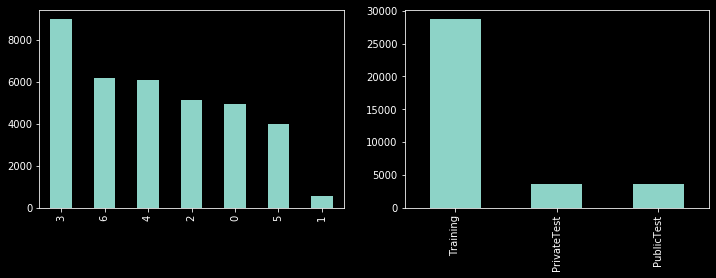

In [19]:
# Class and test/train distribution visualizations (only for Save Mode)
if config.load_npy == False:
    fig = plt.figure(figsize=[12, 8])
    ax1 = fig.add_subplot(221)
    data['label'].value_counts().plot.bar()
    ax2 = fig.add_subplot(222)
    data['Usage'].value_counts().plot.bar()

## Data Loading and Preprocessing: Load Mode

For class and test/train distribution visualizations use Save Mode

In [20]:
# Load data from .npy files
if config.load_npy == True:
    X = np.load('./Datasets/FER-2013/fdata.npy')
    y = np.load('./Datasets/FER-2013/flabels.npy')
    tmask = np.load('./Datasets/FER-2013/ftraintestmask.npy')
    print("Data loaded from .npy files")

## Random samples visualization

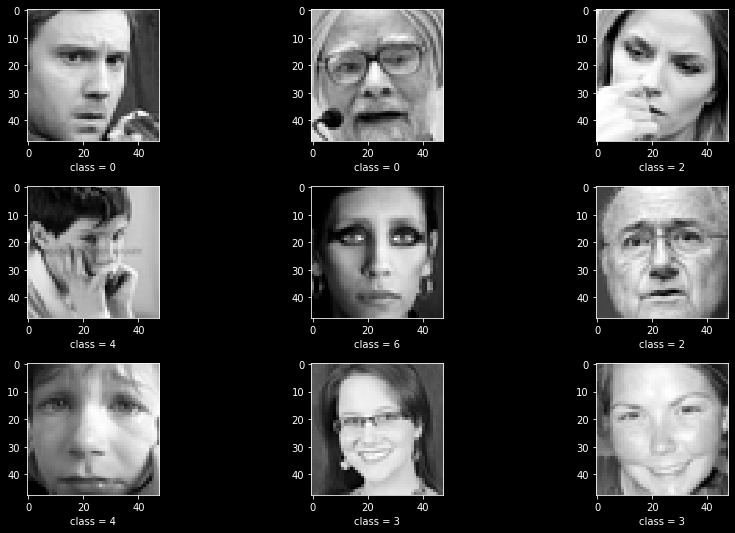

In [21]:
plt.figure(figsize=(12, 12))
for i, pixels in enumerate(X[0:9]):
    plt.subplot(5, 3, i+1)
    plt.imshow(pixels[:,:,0], cmap='gray')  # (256L, 256L, 1L) cannot be plotted therefore we need to get rid of the last dimension -> (256L, 256L)
    plt.xlabel("class = " + "{}".format(np.argmax(y[i], axis=-1))) 
plt.tight_layout()
plt.show()

## Train/test splitting

In [22]:
# Train/test splitting
X_train, y_train = X[tmask], y[tmask]
X_test, y_test = X[~tmask], y[~tmask]

# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Data Generators

In [23]:
# Data Generators
train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_datagen.fit(X_train)
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=config.batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
train_datagen.fit(X_test)
validation_generator = validation_datagen.flow(
    X_test,
    y_test
    
)

## Model Building

In [24]:
# Model Building
model = Sequential()

model.add(Conv2D(config.num_features, kernel_size=(3, 3), activation='relu', input_shape=(config.width, config.height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(config.num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(2*config.num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*config.num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(2*2*config.num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*config.num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(2*2*2*config.num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*config.num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(2*2*2*config.num_features, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2*2*config.num_features, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2*config.num_features, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(config.num_labels, activation='softmax'))

model.compile(loss=config.loss,
              optimizer=config.optimizer,
              metrics=[config.eval_metrics])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_8 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 23, 23, 128)      

In [25]:
callbacks = 

## Model Training

In [26]:
# Model Training
model.fit(X_train, y_train,
          batch_size=config.batch_size,
          epochs=config.epochs,
                                # wandb tracks this, not the prediction on test data later
          #validation_split=0.1,
          callbacks=[
                EarlyStopping(patience=10, verbose=1),
                ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
                WandbCallback(monitor="val_loss", mode="auto", save_weights_only=False, save_model=False)])  # can also operate similarly to ModelCheckpoint as well as a data visualizer

Train on 25838 samples, validate on 2871 samples
Epoch 1/2
25838/25838 [==============================] - 19s 748us/step - loss: 1.8775 - accuracy: 0.2448 - val_loss: 1.7538 - val_accuracy: 0.2668
Epoch 2/2
25838/25838 [==============================] - 16s 625us/step - loss: 1.6371 - accuracy: 0.3479 - val_loss: 1.8200 - val_accuracy: 0.2518


In [27]:
if config.dataset == "MNIST":
    model.fit_generator(
        train_generator, 
        steps_per_epoch=len(x_train) // batch_size, 
        validation_data=validation_generator,
        validation_steps=len(x_test) // batch_size,
        epochs=epochs,
        callbacks=callbacks
    )

# Evaluate Model

In [28]:
score, acc = model.evaluate(X_test, y_test)
print(f"Test loss: {score*100:.5f}")
print(f"Test accuracy: {acc*100:.5f}")

7178/7178 [==============================] - 2s 256us/step
Test loss: 182.70979
Test accuracy: 26.24687


## Result Visualization

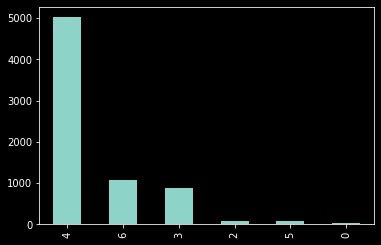

In [29]:
predictions_df = pd.DataFrame({'id': np.where(~tmask)[0]})
predict = model.predict(X_test)
predictions_df['class'] = np.argmax(predict, axis=-1)
predictions_df['class'].value_counts().plot.bar()

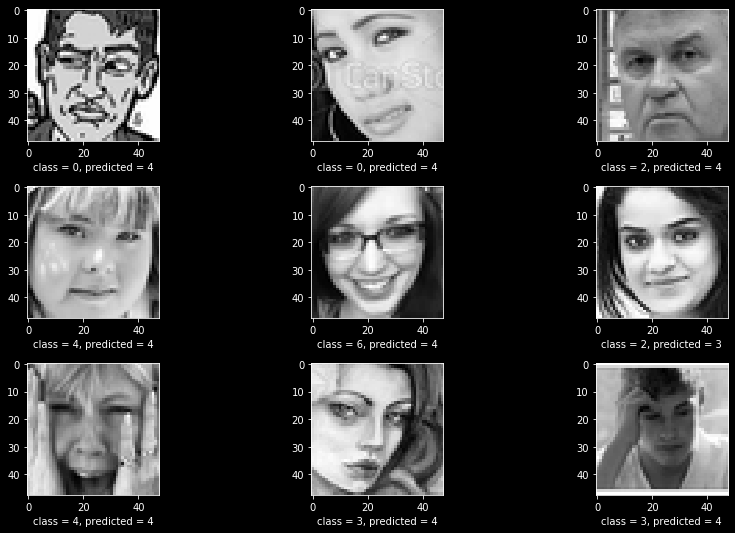

In [30]:
plt.figure(figsize=(12, 12))
for i, pixels in enumerate(X[~tmask][0:9]):
    plt.subplot(5, 3, i+1)
    plt.imshow(pixels[:,:,0], cmap='gray')  # (256L, 256L, 1L) cannot be plotted therefore we need to get rid of the last dimension -> (256L, 256L)
    plt.xlabel("class = " + "{}".format(np.argmax(y[i], axis=-1)) + ", predicted = " + "{}".format(predictions_df.loc[i, "class"])) 
plt.tight_layout()
plt.show()